# SCF Examples

This notebook shows the spherical correlation function (SCF) for BPSK. 



These are all the include files

In [1]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
# import pyaudio
import threading,time
import sys
import cyclostationary

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import integrate

import threading,time
import multiprocessing

from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread


%matplotlib inline

def plotfam(x, t, doplot=True):
    Np = 64
    L = 1
    B = 32 # how far around the center we look
    xs = x
    nx = len(xs) // 2 # center of X axis
    # print("nx=", nx)
    
    # do analysis
    s = cyclostationary.scd_fam(xs, Np, L)
    f = np.absolute(s)
    alpha = cyclostationary.alphaprofile(s)
    (my, mx) = f.shape 
    # print("my, mx", my, mx)
    f = f[(my//2-B):(my//2+B), (mx//2-B):(mx//2 + B)]
    
    if doplot:
        # plot SCD graph
        plt.matshow(f, cmap='hot')
        plt.suptitle(t)
        plt.colorbar()
        plt.show()

        if False:
            # plot histogram
            plt.hist(f)
            plt.suptitle("Histogram " + t)
            plt.show()
            hthresh = 1
            hbelow = sum(f.flatten() <= hthresh)
            hn = f.size
            print("Zero/Total={}/{} (thesh={}, {}% sparse)".format(hbelow, hn, hthresh, 100.0 * hbelow / hn))

            # plot alphaprofile graph
            plt.plot(alpha)
            plt.suptitle(t + "-alpha")
            plt.show()
    return alpha, s

def gen_bpsk(Nbits, noisedB = -100, sigdB = 0, doplot=False):
    fs = 44100  # sampling rate
    baud = 300  # symbol rate
    Ns = fs//baud
    N = Nbits * Ns
    f0 = 1800
    bits = randn(Nbits,1) > 0
    imp = zeros(N)
    imp[::Ns] = bits.ravel()*2-1

    h = signal.firwin(Ns*4,1.0/Ns)
    imp_sinc = signal.fftconvolve(imp,h,mode='full')
    t = r_[0.0:len(imp_sinc)]/fs
    
    nscale = pow(10.0, (noisedB / 20))
    sscale = pow(10.0, (sigdB / 20))
    BPSK = imp_sinc*sin(2*pi*f0*t)
    BPSK = BPSK / max(BPSK)
    BPSK_s = sscale * BPSK + nscale * np.random.normal(0,1,len(imp_sinc))
    BPSK_s = BPSK_s / max(BPSK_s)
    if doplot:
        plot(t,BPSK_s)
    return t, BPSK_s

Using matplotlib backend: <object object at 0x106ff87f0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


This generates BPSK at a given signal and noise level

This is one of the tests that sweeps the noise level and returns the largest values of the alpha profile


In [2]:
# returns the set containing the peaks largest indices for the alpha profile for BPSK there should be 2 peaks
def genandplot(noisedB, peaks=2, Nbits=128, doplot=True):
    t, BPSK_s = gen_bpsk(Nbits, noisedB, doplot=doplot)
    alpha, scd = plotfam(BPSK_s, f"SCF of pulse shaped BPSK noise={noisedB}", doplot=doplot)
    return set(np.argpartition(alpha, len(alpha)-peaks)[-peaks:]), scd

def testbpsk(Nbits, doplot=False):
    result = []
    testdB = -20
    mindex, origscd = genandplot(testdB, Nbits=Nbits, doplot=doplot)
    print(f'scd.shape={origscd.shape}')
    result.append((testdB, mindex))
    while True:
        testdB += 1
        nindex, scd = genandplot(testdB, Nbits=Nbits, doplot=doplot)
        result.append((testdB, nindex))
        if nindex != mindex:
            break
    genandplot(testdB, Nbits=Nbits, doplot=doplot)
    return -testdB, result


Signal generation parameters (BPSK)

This runs an initial test at good SNR to use as a reference

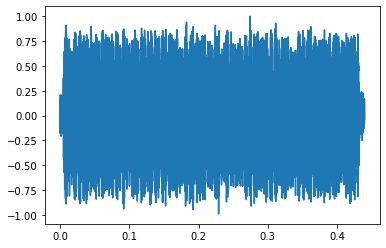

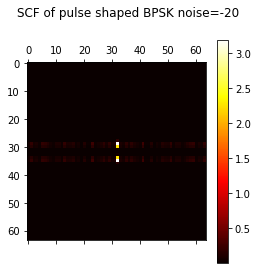

scd.shape=(64, 32768)
bits=2^7: Score_SNR=20


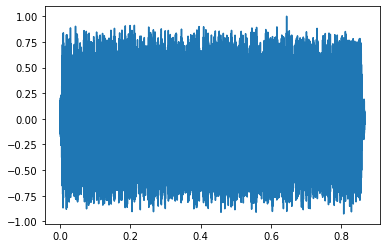

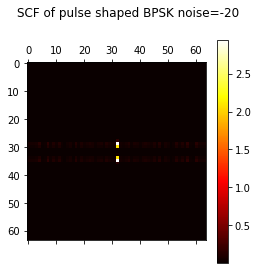

scd.shape=(64, 65536)
bits=2^8: Score_SNR=20


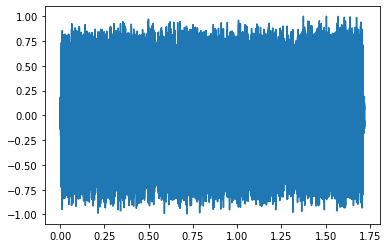

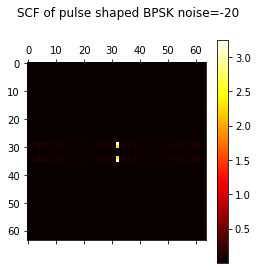

scd.shape=(64, 131072)
bits=2^9: Score_SNR=20


KeyboardInterrupt: 

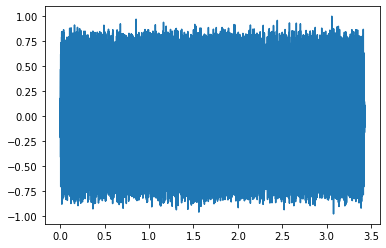

In [3]:
for i in range(7,16):
    bits = 1 << i
    t, r = testbpsk(bits, doplot=False)
    print(f'bits=2^{i}: Score_SNR={t}')


Prints the noise dB and largest values

In [ ]:
print(f'SNR_score={-t}, points={r}')

Plots the time domain and SCD when the test fails

In [ ]:
genandplot(t, True)